In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
import statistics
import seaborn as sns
import tensorflow as tf
import pickle
from scipy.stats import pearsonr
import copy
import math
from tqdm import tqdm
import random 

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#plot sensitivity distribution
def plot_sensitivity_with_bootstrap(M, N=500, dir = 'sensitivity/', outdir='sensitivity_graphs/', save=False):
    os.makedirs(outdir, exist_ok=True)
    target_sensitivity = pd.read_csv('target_sensitivity.csv')
    norm_sens = target_sensitivity['sensitivity_normalized']
    #target_order = [12, 13, 10, 1, 4, 7, 11, 2, 8, 9, 5, 6, 0, 3]
    target_order = [12, 13, 10, 11, 1, 4, 0, 7, 3, 6, 2, 9, 8, 5]
    fund_mom_idx = [12, 10, 11]
    fund_char_idx = [0, 1, 2, 3, 4]
    fund_family_idx = [5, 6, 7, 8, 9]
    sentiment_idx = [13]
    group_idx_list = [sentiment_idx, fund_mom_idx, fund_char_idx, fund_family_idx]
    target_groups_medians = []
    for group in group_idx_list:
        target_group_median_avg = np.mean(norm_sens[group])
        target_groups_medians.append(target_group_median_avg)
    target_median_sum = np.sum(target_groups_medians)
    target_medians_norm = [m/target_median_sum for m in target_groups_medians]
    target_norm_sens = [norm_sens[i] for i in target_order]
    #read all csv and store to a mapping
    identifier_list = []
    allfiles = {} #filename -> csv
    for filename in os.listdir('sensitivity'):
        identifier_list.append(filename)
        currfile = pd.read_csv(f'{dir}{filename}')
        allfiles[filename] = currfile
    ################################################################################
    def plot_sensitivity_distribution(data, title='', save=save):
        data = np.array(data)
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 3, 1)
        plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
        plt.title(f'Histogram\n{title}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.tight_layout()
        if save: 
            plt.savefig(f'{outdir}{title}.png')
        plt.show()
    all_features = ['ages', 'flow',
            'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
            'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
            'F_r12_2', 'sentiment']
    def get_stats(feature_sensitivity_list):
        medians = []
        lower_percentiles = []
        upper_percentiles = []
        for sensitivity_list in feature_sensitivity_list:
            medians.append(np.median(sensitivity_list))
            lower_percentiles.append(np.percentile(sensitivity_list, 25))
            upper_percentiles.append(np.percentile(sensitivity_list, 75))
        return medians, lower_percentiles, upper_percentiles
    def plot_box_chart(features, medians, lower_percentiles, upper_percentiles, targets=None, order = target_order, title='', save=save):
        if not order:
            order = np.argsort(medians)[::-1]
        features = [features[i] for i in order]
        medians = [medians[i] for i in order]
        lower_percentiles = [lower_percentiles[i] for i in order]
        upper_percentiles = [upper_percentiles[i] for i in order]
        lower_errors = [mean - lower for mean, lower in zip(medians, lower_percentiles)]
        upper_errors = [upper - mean for mean, upper in zip(medians, upper_percentiles)]
        plt.figure(figsize=(10, 6))
        colors = ['blue', 'darkgreen', 'blue', 'blue', 'pink', 'pink', 'pink', 'lightgreen', 'pink', 'lightgreen', 'pink', 'lightgreen', 'lightgreen', 'lightgreen']
        bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5, color=colors)
        if targets: 
            for i, bar in enumerate(bar_plot):
                plt.scatter(targets[i], bar.get_y() + bar.get_height()/2, color='red', marker='o', zorder=5)
        plt.xlabel('Sensitivity')
        plt.title('Sensitivity Box Chart '+title)
        plt.gca().invert_yaxis()
        if save:
            plt.savefig(outdir+"individual_variable_box_chart{}.png".format(title), dpi=300, bbox_inches='tight')
        plt.show()
    def plot_group_box_chart(groups, medians, lower_percentiles, upper_percentiles, targets, title='', save=save):
        plt.figure(figsize=(10, 6))
        colors = ['darkgreen', 'blue', 'pink', 'lightgreen' ]
        lower_errors = [mean - lower for mean, lower in zip(medians, lower_percentiles)]
        upper_errors = [upper - mean for mean, upper in zip(medians, upper_percentiles)]
        bar_plot = plt.barh(groups, medians, xerr=[lower_errors, upper_errors], capsize=5, color=colors)
        #bar_plot = plt.barh(groups, medians, capsize=5, color=colors)
        if targets: 
            for i, bar in enumerate(bar_plot):
                plt.scatter(targets[i], bar.get_y() + bar.get_height()/2, color='red', marker='o', zorder=5)
        plt.xlabel('Sensitivity')
        plt.title('Group Sensitivity Box Chart '+title)
        plt.gca().invert_yaxis()
        if save:
            plt.savefig(outdir+"group_variable_box_chart{}.png".format(title), dpi=300, bbox_inches='tight')
        plt.show()
    ############################################################# 
    medians = []
    p25s = []
    p75s = []
    numloops = N if M>1 else 1
    for i in tqdm(range(numloops)):
        if M>1:
            selected_models = random.sample(identifier_list, M)
        else:
            selected_models = identifier_list.copy()
        all_feature_sensitivities= []
        for feature in all_features:
            feature_sense_normalized_list = []
            for identifier in selected_models:
                df_sensitivity = allfiles[identifier]
                feature_sens_normalized = df_sensitivity.loc[df_sensitivity['variables'] == feature, 'sensitivity_normalized'].values[0]
                feature_sense_normalized_list.append(feature_sens_normalized)
            #plot_sensitivity_distribution(feature_sense_normalized_list, f'sensitivity empirical distribution {feature}', 'sensitivity_distribution_plots')
            all_feature_sensitivities.append(feature_sense_normalized_list)
        median, p25, p75 = get_stats(all_feature_sensitivities)
        medians.append(median)
        p25s.append(p25)
        p75s.append(p75)
    #get element-wise mean for final plot 
    final_medians = np.mean(np.array(medians), axis=0)
    final_p25 = np.mean(np.array(p25s), axis=0)
    final_p75 = np.mean(np.array(p75s), axis=0)
    plot_box_chart(all_features, final_medians, final_p25, final_p75, targets=target_norm_sens, title=f'N{N}M{M}')
    #take average of each variable group and renormalize 
    groups_medians = []
    groups_p25 = []
    groups_p75 = []
    for group in group_idx_list:
        curr_group_median_avg = np.mean(final_medians[group])
        curr_group_p25_avg = np.mean(final_p25[group])
        curr_group_p75_avg = np.mean(final_p75[group])
        groups_medians.append(curr_group_median_avg)
        groups_p25.append(curr_group_p25_avg)
        groups_p75.append(curr_group_p75_avg)
    groups_medians_sum = np.sum(groups_medians)
    groups_p25_sum = np.sum(groups_p25)
    groups_p75_sum = np.sum(groups_p75)
    groups_medians_norm = [m/groups_medians_sum for m in groups_medians]
    groups_p25_norm = [b/groups_medians_sum for b in groups_p25]
    groups_p75_norm = [t/groups_medians_sum for t in groups_p75]
    plot_group_box_chart(groups=['Sentiment', "Fund mom", "Fund char", "Fund Family"], medians=groups_medians_norm, lower_percentiles=groups_p25_norm, upper_percentiles=groups_p75_norm, targets=target_medians_norm, title=f'N{N}M{M}')

100%|██████████| 10000/10000 [01:45<00:00, 94.68it/s]


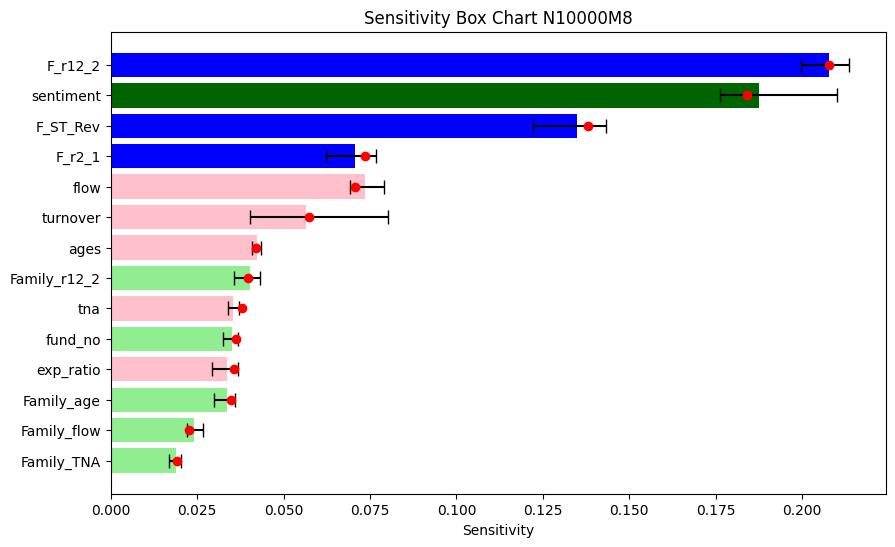

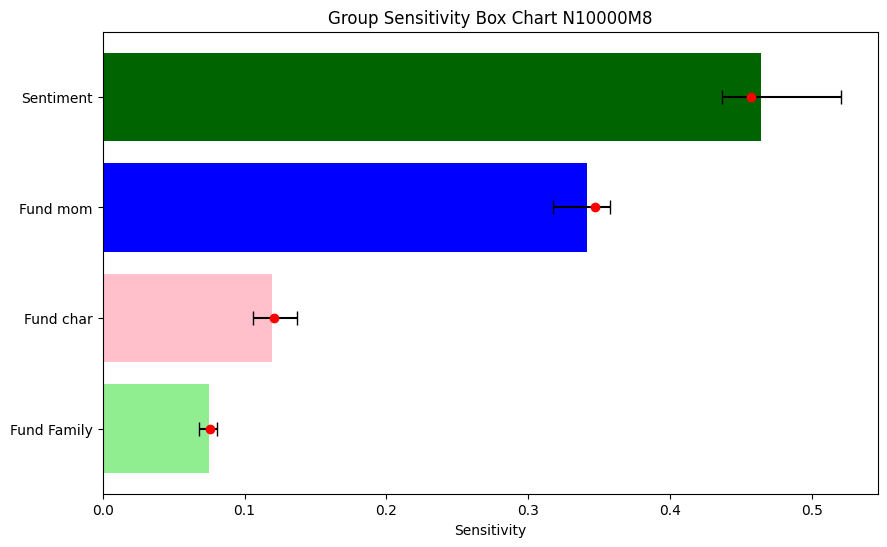

100%|██████████| 10000/10000 [06:20<00:00, 26.26it/s]


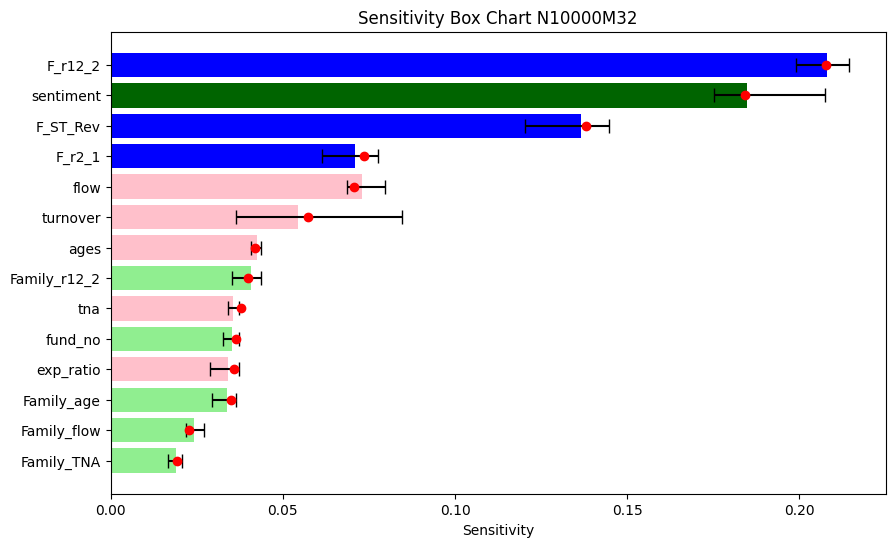

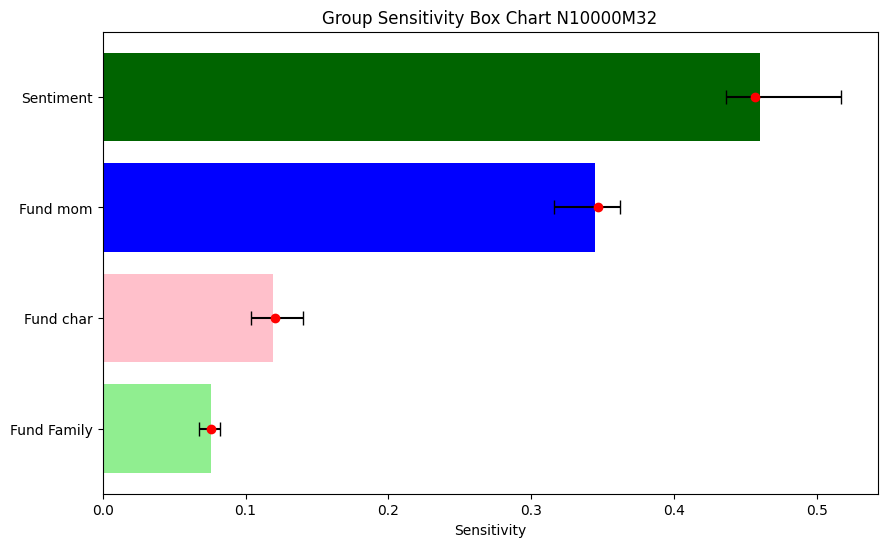

In [3]:
for m in [8, 32]:
    for n in [10000]:
        plot_sensitivity_with_bootstrap(m,n, outdir='all_saved_plots/', save=True)